In [3]:
import numpy as np
import scipy.spatial 
import matplotlib.pyplot as plt
import sklearn as skl

# Preprocess the data set

In [4]:
data = open('house-votes-84.data', 'r')
lines = data.readlines()

row = len(lines)
col = len(lines[0][:len(lines[0])-1].split(",")) # -1 to get rid of \n

X = np.zeros((row,col))
y = np.ones((row,1))

for i in range(row):
    l = lines[i][:len(lines[i])-1].split(",")
    if l[0] == "democrat":
        y[i] = -1   
    for j in range(1,len(l)):
        if l[j] == "y":
            X[i][j] = 1
        elif l[j] == "n":
            X[i][j] = -1

X = X[:,1:] # drop 1st column

# reorder the data based on group, sth strong happens
#data = np.hstack((y,X))
#data = data[np.argsort(data[:,0],kind = "heapsort")]
#y = data[:,0]
#X = data[:,1:]

# Spectral Clustering

In [29]:
def eta(tt, rr):
    val = np.exp( - (tt**2)/(2*rr**2) ) 
    return val.astype(float) 

In [30]:
r_space = np.linspace(0,4,101)
dist = scipy.spatial.distance_matrix( X, X, p =2)
acc = []
accn = []

for r in r_space[1:101]:
    W = eta(dist, r)
    d = np.sum(W, axis=1)
    D = np.diag(d)
    Ds = np.diag(1/np.sqrt(d))
    
    # compute graph Laplacian matrix
    L = D - W # unnormalized
    Ln = np.dot(Ds, np.dot((D - W),Ds)) # normalized
    
    # eigen decomposition for both
    ll, VV = np.linalg.eigh(L)
    idx = ll.argsort()
    l = ll[idx]
    V = VV[:, idx]

    lln, VVn = np.linalg.eigh(Ln)
    idxn = lln.argsort()
    ln = lln[idxn]
    Vn = VVn[:, idxn]
    
    # calculate accuracy
    c1 = np.sign(V[:,1]).reshape(y.shape)
    acc.append(max(np.sum(c1 == y),np.sum(c1!=y))/435)
    
    c2 = np.sign(Vn[:,1]).reshape(y.shape)
    accn.append(max(np.sum(c2 == y),np.sum(c2!=y))/435)

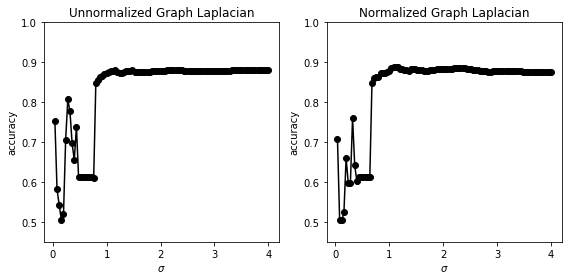

In [31]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].plot(r_space[1:101],acc,"-ok")
ax[0].set_title('Unnormalized Graph Laplacian')
ax[0].set_xlabel('$\sigma$')
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.45,1)


ax[1].plot(r_space[1:101],accn,"-ok")
ax[1].set_title('Normalized Graph Laplacian')
ax[1].set_xlabel('$\sigma$')
ax[1].set_ylabel('accuracy')
ax[1].set_ylim(0.45,1)

fig.tight_layout()

In [32]:
print("optimal sigma for unnormalized graph is",r_space[acc.index(np.max(acc))+1])
print("optimal sigma for normalized graph is ",r_space[accn.index(np.max(accn))+1])

optimal sigma for unnormalized graph is 1.16
optimal sigma for normalized graph is  1.08


In [33]:
r_space[np.array(np.where(acc == np.max(acc))[0])+1]

array([1.16, 1.48, 2.12, 2.16, 2.2 , 2.24, 2.28, 2.32, 2.36, 2.4 , 3.32,
       3.36, 3.4 , 3.44, 3.48, 3.52, 3.56, 3.6 , 3.64, 3.68, 3.72, 3.76,
       3.8 , 3.84, 3.88, 3.92, 3.96, 4.  ])

# Semi-supervised Learning

In [10]:
accList = []
r = r_space[acc.index(np.max(acc))+1]

for M in [5,10,20,40]:
    Y = y[0:M]
    for K in [2,3,4,5,6]:
        dist = scipy.spatial.distance_matrix( X, X, p =2)

        W = eta( dist, r)

        d = np.sum(W, axis=1) 

        D = np.diag(d)

        L = D - W 

        ll, VV = np.linalg.eigh(L)

        idx = ll.argsort()
        l = ll[idx]
        V = VV[:, idx]

        Vp = V[0:M, 0:K]

        from sklearn.linear_model import Ridge

        SSLRidge = Ridge(alpha = 1e-8, fit_intercept=False)

        SSLRidge.fit(Vp, Y)

        c_hat = SSLRidge.coef_.reshape((-1,1))

        Y_pred =  np.dot(V[:, 0:K], c_hat)

        c=np.sign(Y_pred)
        accList.append(np.sum(c == y)/435)
        
        
np.reshape(accList,(4,5)) # row for M data subsets, col for # of eigenvalues

array([[0.88965517, 0.88965517, 0.83908046, 0.86666667, 0.89195402],
       [0.88735632, 0.82068966, 0.85747126, 0.75402299, 0.72873563],
       [0.88275862, 0.82298851, 0.86436782, 0.84137931, 0.87586207],
       [0.88045977, 0.83908046, 0.87586207, 0.87816092, 0.86436782]])